## Example plots from "replay season" data

Running `airsenal_replay_season` now writes a json file, with data on the squads selected, and expected and actual points.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read the json file.

In [2]:
current_dir = os.getcwd()
json_filepath = os.path.join(current_dir, "..", "airsenal","data","Replay_2122_GW1_GW38_202210071157.json")
data = json.load(open(json_filepath))
data["gameweeks"][0].keys()

dict_keys(['gameweek', 'predictions_tag', 'starting_11', 'subs', 'vice_captain', 'captain', 'expected_points', 'actual_points'])

### Player history plot 

Get a unique list of all the players we picked over the course of the season

In [3]:
picked_players = []
for gw in data["gameweeks"]:
    for player in gw['starting_11']:
        picked_players.append(player)
    for player in gw["subs"]:
        picked_players.append(player)
picked_players = list(set(picked_players))


Order this list by position, and price, to hopefully tidy up the plot we'll make below

In [4]:
# all players from the 21/22 season - put gameweek=38 to ensure we capture those that joined in Jan transfer window
from airsenal.framework.utils import list_players
all_players = [p.name for p in list_players(season="2122",position="GK", gameweek=38)]
all_players += [p.name for p in list_players(season="2122",position="DEF", gameweek=38)]
all_players += [p.name for p in list_players(season="2122",position="MID", gameweek=38)]
all_players += [p.name for p in list_players(season="2122",position="FWD", gameweek=38)]

Now use the indices of our picked players in the all_players list, to order the picked players list.

In [5]:
player_indices = [(p, all_players.index(p)) for p in picked_players]
sorted_players = [p for p, _ in sorted(player_indices, key=lambda pair: pair[1])]

In [6]:
data["gameweeks"][0].keys()

dict_keys(['gameweek', 'predictions_tag', 'starting_11', 'subs', 'vice_captain', 'captain', 'expected_points', 'actual_points'])

Make a "broken_bar" chart showing when each player was in the starting 11 / sub / captain over the course of the season. https://matplotlib.org/2.0.2/examples/pylab_examples/broken_barh.html

For each call to `ax.broken_barh` we want, for the x-axis, a list of tuples, where each tuple corresponds to a run of gameweeks when the player was e.g. in the starting 11, in the format (starting_gw-0.5,num_gw).  The y-axis (second argument of `ax.broken_barh` is a tuple of form (index_of_player+0.1, 1) (i.e. the '1' is the height of the horizontal bar).   For each player we will make separate lists of tuples for runs in the starting 11, for runs as sub, and for runs as captain.

In [7]:
playerdicts = {}
for p in sorted_players:
    playerdicts[p] = {"starting_11_periods": [], "subs_periods": [], "captain_periods": [], "starting_11_since": None, "subs_since": None, "captain_since": None}
for gw in data["gameweeks"]:
    for p in sorted_players:
        for status in ["starting_11","subs", "captain"]:
            if (isinstance(gw[status], list) and p in gw[status]) or \
                (isinstance(gw[status], str) and p==gw[status]):
                # if newly in (starting 11|sub|captain)
                if not playerdicts[p][status+"_since"]:
                    playerdicts[p][status+"_since"] = gw["gameweek"]      
            else:
                # if newly out of (starting 11|sub|captain)
                if playerdicts[p][status+"_since"]:
                    period = (playerdicts[p][status+"_since"]-0.5, gw["gameweek"] - playerdicts[p][status+"_since"])
                    playerdicts[p][status+"_periods"].append(period)
                    playerdicts[p][status+"_since"] = None
# at end of loop over gameweeks, round off any still-going periods
for p in sorted_players:
    for status in ["starting_11","subs", "captain"]:
        if playerdicts[p][status+"_since"]:
            period = (playerdicts[p][status+"_since"]-0.5, gw["gameweek"]+0.5)
            playerdicts[p][status+"_periods"].append(period)
    

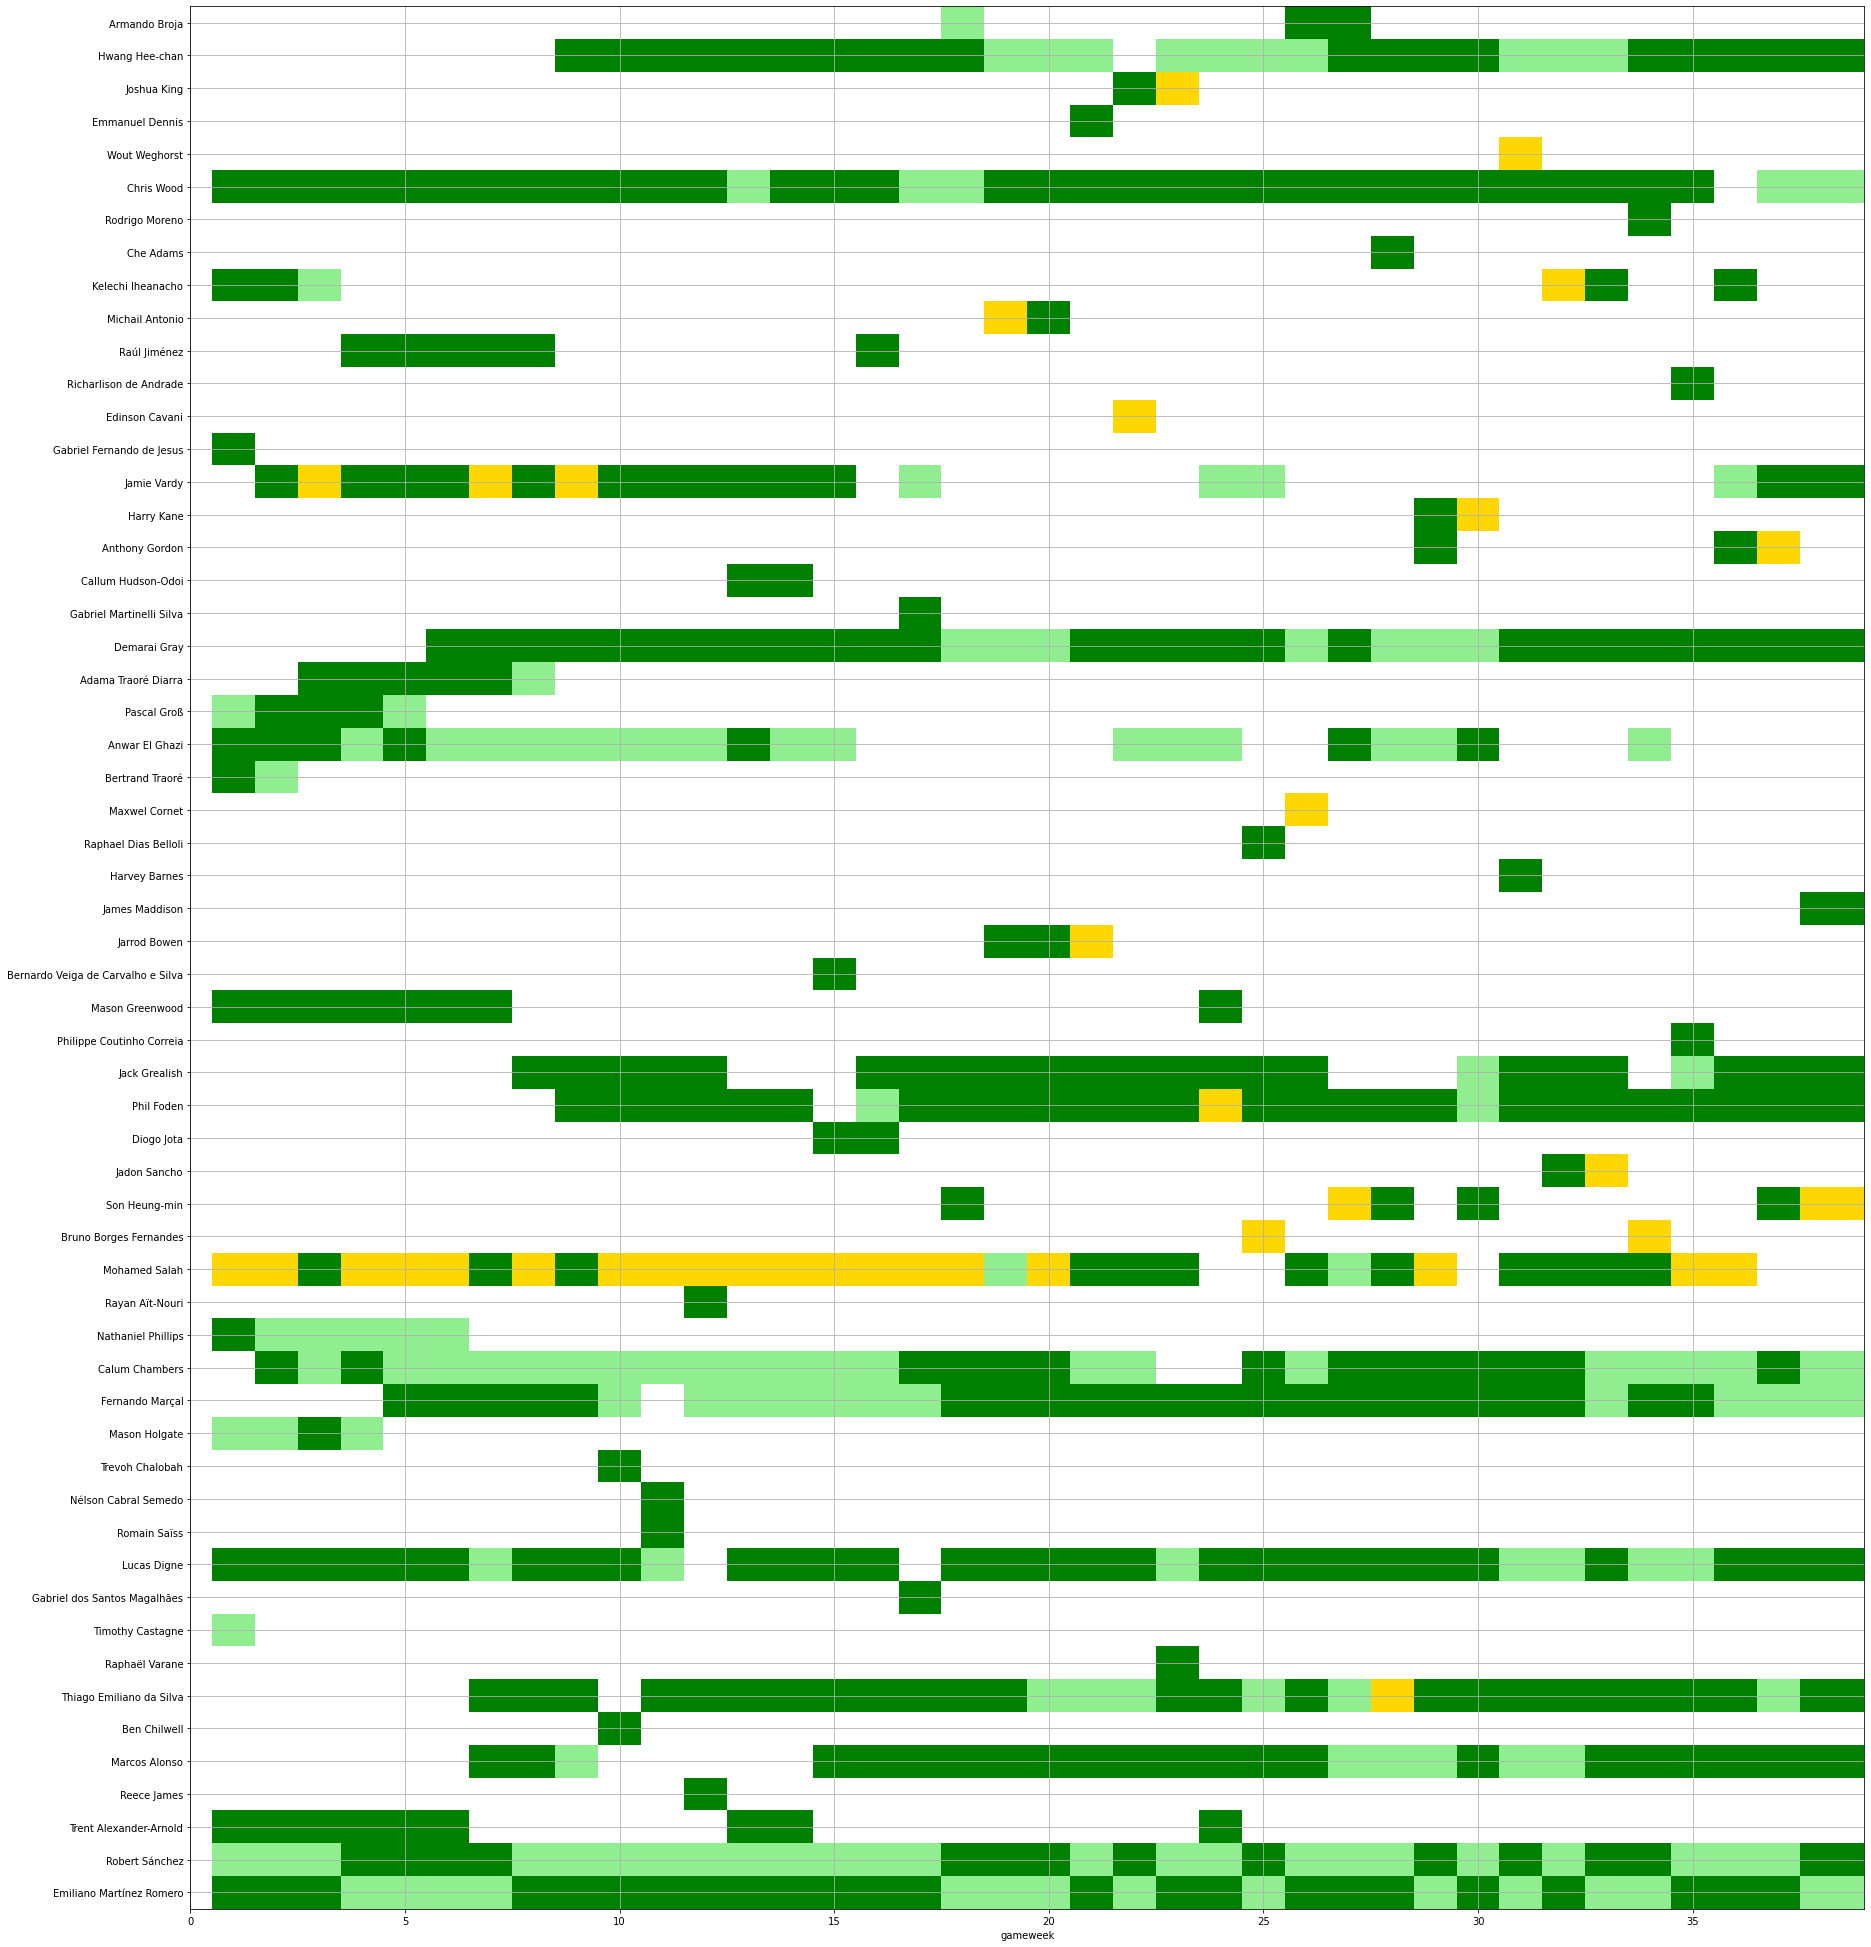

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(30,35))
fig.figsize = (30,10)
for i, p in enumerate(sorted_players):
    ax.broken_barh(playerdicts[p]["starting_11_periods"], (i+0.5, 1), facecolors='green')
    ax.broken_barh(playerdicts[p]["subs_periods"], (i+0.5, 1), facecolors='lightgreen')
    ax.broken_barh(playerdicts[p]["captain_periods"], (i+0.5, 1), facecolors='gold')

ax.set_ylim(0.5, len(sorted_players)+0.5)
ax.set_xlim(0, 39)
ax.set_xlabel('gameweek')
ax.set_yticks(list(range(1,len(sorted_players)+1)))
ax.set_yticklabels(sorted_players)
ax.grid(True)

plt.show()

#### Some observations:
* Only picked two keepers through the whole season, and alternated between them (presumably based on fixtures)
* Captained Salah a lot through first part of the season, but not at all as form dropped after AFCON.
* Really liked Chris Wood!!

### Predicted and actual points scored

Now lets make plots of week-by-week, and cumulative, expected and actual points for the squad:

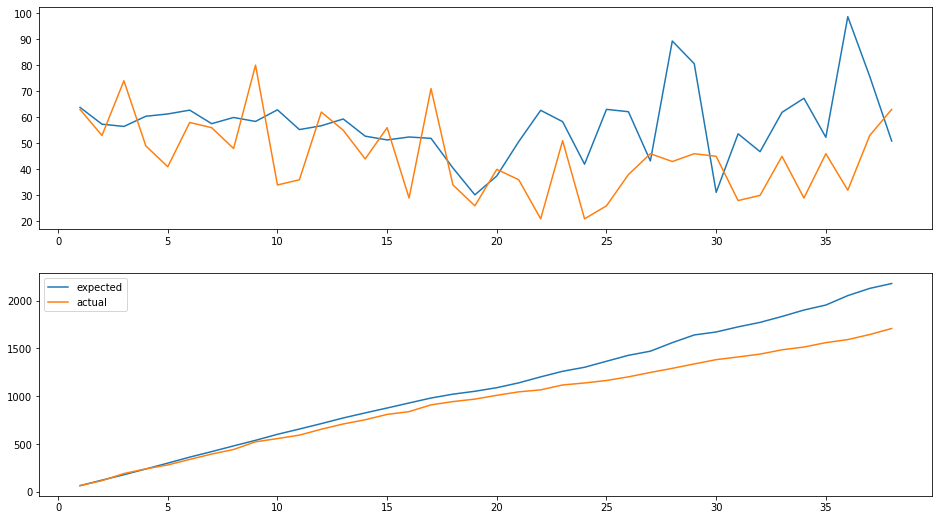

In [10]:
xvals = list(range(1,len(data["gameweeks"])+1))
expvals = []
actualvals = []
for gw in data["gameweeks"]:
    expvals.append(gw["expected_points"])
    actualvals.append(gw["actual_points"])

fig, axes = plt.subplots(2,1,figsize=(16,9))    
axes[0].plot(xvals,expvals)
axes[0].plot(xvals,actualvals)
axes[1].plot(xvals,np.cumsum(expvals), label="expected")
axes[1].plot(xvals,np.cumsum(actualvals), label="actual")
axes[1].legend()
                

Looks like our expected points were wildly optimistic, especially for some weeks at the end - perhaps this is an example of big players being rested, perhaps for Champions League games, or just being unlikely to play both games in a Double Gameweek, which we currently don't take into account.